Hopefully this notebook is now a working example of the multinomial player model.

In [1]:
import os

import pandas as pd

import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt


Get a sample of player data.  Just look at forwards, with data up to the middle of the 2019/20 season.

In [2]:
from airsenal.framework.prediction_utils import process_player_data
from airsenal.framework.utils import get_player, NEXT_GAMEWEEK
from airsenal.framework.season import CURRENT_SEASON

In [3]:
def get_player_data(position, season="1920", latest_gameweek=38):
    data = process_player_data(position, season, latest_gameweek)
    return data

In [4]:
data = get_player_data("FWD")

Filling history dataframe for Sergio Agüero: 0/87 done
Filling history dataframe for Pierre-Emerick Aubameyang: 1/87 done
Filling history dataframe for Harry Kane: 2/87 done
Filling history dataframe for Jamie Vardy: 3/87 done
Filling history dataframe for Gabriel Fernando de Jesus: 4/87 done
Filling history dataframe for Roberto Firmino: 5/87 done
Filling history dataframe for Alexandre Lacazette: 6/87 done
Filling history dataframe for Marcus Rashford: 7/87 done
Filling history dataframe for Romelu Lukaku: 8/87 done
Filling history dataframe for Raúl Jiménez: 9/87 done
Filling history dataframe for Tammy Abraham: 10/87 done
Filling history dataframe for Callum Wilson: 11/87 done
Filling history dataframe for Danny Ings: 12/87 done
Filling history dataframe for Marko Arnautovic: 13/87 done
Filling history dataframe for Sébastien Haller: 14/87 done
Filling history dataframe for Olivier Giroud: 15/87 done
Filling history dataframe for Michy Batshuayi: 16/87 done
Filling history datafram

this gives us a dict with keys:
```
"player_ids" (list of ints),
"nplayer" (int), 
"nmatch" (int), 
"minutes" (numpy array with shape (nplayer, nmatch)), 
"y" (numpy array with shape (nplayer, nmatch, 3)), 
"alpha" (numpy array with shape (3,))
```


### numpyro model

The below took a lot of iterations to figure out how to broadcast over the right dimensions.
Hopefully it's sort-of right...


In [5]:
def model(nplayer, nmatch, minutes, y, alpha):
    theta = dist.Dirichlet(concentration=alpha)
    # one sample from the prior per player
    with numpyro.plate("nplayer", nplayer) as player_index:
        dprobs = numpyro.sample("probs", theta) 
    # now it's all about how to broadcast in the right dimensions.....
    prob_score = numpyro.deterministic("prob_score",dprobs[:,0,None] * (minutes / 90.))
    prob_assist = numpyro.deterministic("prob_assist",dprobs[:,1,None] * (minutes / 90.))
    prob_neither = numpyro.deterministic("prob_neither",dprobs[:,2,None] * (minutes / 90.) + (90. - minutes))
    theta_mins = dist.Multinomial(
                probs=jnp.moveaxis(jnp.array([prob_score, prob_assist, prob_neither]),0,2)
    )
    return numpyro.sample("obs", theta_mins, obs=y)

In [6]:
def fit_model(data, model):
    kernel = NUTS(model)
    mcmc = MCMC(
    kernel,
    num_warmup=1500,
    num_samples=3000,
    num_chains=1,
    progress_bar=True
    )
    rng_key, rng_key_predict = random.split(random.PRNGKey(44))
    mcmc.run(rng_key,
         data["nplayer"],
         data["nmatch"],
         data["minutes"],
         data["y"],
         data["alpha"]
    )
    return mcmc.get_samples()

In [7]:
def get_probs(player_index, samples):
    prob_score = float(samples["probs"][:,player_index,0].mean())
    prob_assist = float(samples["probs"][:,player_index,1].mean())
    prob_neither = float(samples["probs"][:,player_index,2].mean())
    return (prob_score, prob_assist, prob_neither)

In [8]:
def create_dataframe(names, samples):
    prob_dict = {"name":[],"prob_score": [], "prob_assist": [], "prob_neither": []}
    for i, pid in enumerate(names):
        pid = int(pid)
        prob_dict["name"].append(get_player(pid).name)
        probs = get_probs(i, samples)
        prob_dict["prob_score"].append(probs[0])
        prob_dict["prob_assist"].append(probs[1])
        prob_dict["prob_neither"].append(probs[2])
    df = pd.DataFrame(prob_dict)
    return df

In [9]:
def run_model(position="FWD",season="1920",latest_gameweek=38):
    data = get_player_data(position, season, latest_gameweek)
    samples = fit_model(data, model)
    df = create_dataframe(data["player_ids"], samples)
    return df

Now go through the whole chain for each position in turn

In [10]:
df_fwd = run_model("FWD", season=CURRENT_SEASON, latest_gameweek=NEXT_GAMEWEEK)
df_mid = run_model("MID", season=CURRENT_SEASON, latest_gameweek=NEXT_GAMEWEEK)
df_def = run_model("DEF", season=CURRENT_SEASON, latest_gameweek=NEXT_GAMEWEEK)

Filling history dataframe for Harry Kane: 0/75 done
Filling history dataframe for Romelu Lukaku: 1/75 done
Filling history dataframe for Jamie Vardy: 2/75 done
Filling history dataframe for Pierre-Emerick Aubameyang: 3/75 done
Filling history dataframe for Roberto Firmino: 4/75 done
Filling history dataframe for Timo Werner: 5/75 done
Filling history dataframe for Gabriel Fernando de Jesus: 6/75 done
Filling history dataframe for Edinson Cavani: 7/75 done
Filling history dataframe for Alexandre Lacazette: 8/75 done
Filling history dataframe for Danny Ings: 9/75 done
Filling history dataframe for Dominic Calvert-Lewin: 10/75 done
Filling history dataframe for Patrick Bamford: 11/75 done
Filling history dataframe for Anthony Martial: 12/75 done
Filling history dataframe for Richarlison de Andrade: 13/75 done
Filling history dataframe for Michail Antonio: 14/75 done
Filling history dataframe for Ollie Watkins: 15/75 done
Filling history dataframe for Callum Wilson: 16/75 done
Filling hist

sample: 100%|████████| 4500/4500 [00:14<00:00, 304.95it/s, 7 steps of size 4.36e-01. acc. prob=0.82]


Filling history dataframe for Mohamed Salah: 0/235 done
Filling history dataframe for Bruno Miguel Borges Fernandes: 1/235 done
Filling history dataframe for Sadio Mané: 2/235 done
Filling history dataframe for Kevin De Bruyne: 3/235 done
Filling history dataframe for Raheem Sterling: 4/235 done
Filling history dataframe for Heung-Min Son: 5/235 done
Filling history dataframe for Marcus Rashford: 6/235 done
Filling history dataframe for Jadon Sancho: 7/235 done
Filling history dataframe for Riyad Mahrez: 8/235 done
Filling history dataframe for Kai Havertz: 9/235 done
Filling history dataframe for Christian Pulisic: 10/235 done
Filling history dataframe for Jack Grealish: 11/235 done
Filling history dataframe for Phil Foden: 12/235 done
Filling history dataframe for Paul Pogba: 13/235 done
Filling history dataframe for Mason Mount: 14/235 done
Filling history dataframe for Diogo Jota: 15/235 done
Filling history dataframe for Ilkay Gündogan: 16/235 done
Filling history dataframe for Ma

Filling history dataframe for Andreas Pereira: 156/235 done
Filling history dataframe for Anthony Elanga: 157/235 done
Filling history dataframe for Jeff Hendrick: 158/235 done
Filling history dataframe for Jacob Murphy: 159/235 done
Filling history dataframe for Marco Stiepermann: 160/235 done
Filling history dataframe for Kenny McLean: 161/235 done
Filling history dataframe for Onel Hernández: 162/235 done
Filling history dataframe for Przemyslaw Placheta: 163/235 done
Filling history dataframe for Josh Martin: 164/235 done
Filling history dataframe for Pierre Lees-Melou: 165/235 done
Filling history dataframe for Christos Tzolis: 166/235 done
Filling history dataframe for Nathan Tella: 167/235 done
Filling history dataframe for Pierre-Emile Højbjerg: 168/235 done
Filling history dataframe for Dan Gosling: 169/235 done
Filling history dataframe for Tom Cleverley: 170/235 done
Filling history dataframe for Nathaniel Chalobah: 171/235 done
Filling history dataframe for Will Hughes: 172

sample: 100%|███████| 4500/4500 [00:38<00:00, 118.21it/s, 15 steps of size 2.86e-01. acc. prob=0.87]


Filling history dataframe for Trent Alexander-Arnold: 0/190 done
Filling history dataframe for Andrew Robertson: 1/190 done
Filling history dataframe for Virgil van Dijk: 2/190 done
Filling history dataframe for César Azpilicueta: 3/190 done
Filling history dataframe for Benjamin Chilwell: 4/190 done
Filling history dataframe for João Pedro Cavaco Cancelo: 5/190 done
Filling history dataframe for Rúben Santos Gato Alves Dias: 6/190 done
Filling history dataframe for Marcos Alonso: 7/190 done
Filling history dataframe for Thiago Emiliano da Silva: 8/190 done
Filling history dataframe for Antonio Rüdiger: 9/190 done
Filling history dataframe for Kurt Zouma: 10/190 done
Filling history dataframe for Reece James: 11/190 done
Filling history dataframe for Lucas Digne: 12/190 done
Filling history dataframe for Jonny Evans: 13/190 done
Filling history dataframe for Ricardo Domingos Barbosa Pereira: 14/190 done
Filling history dataframe for Timothy Castagne: 15/190 done
Filling history datafra

Alpha is [ 2.20695308  3.80735945 66.82079385]


sample: 100%|███████| 4500/4500 [00:29<00:00, 151.24it/s, 15 steps of size 2.96e-01. acc. prob=0.84]


Text(0, 0.5, 'P(assist)')

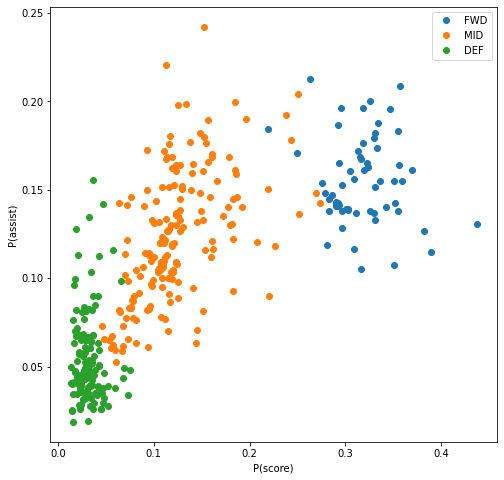

In [11]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8))
plt.plot(df_fwd['prob_score'], df_fwd['prob_assist'], 'o', label='FWD')
plt.plot(df_mid['prob_score'], df_mid['prob_assist'], 'o', label='MID')
plt.plot(df_def['prob_score'], df_def['prob_assist'], 'o', label='DEF')
plt.legend()
plt.xlabel('P(score)')
plt.ylabel('P(assist)')


In [68]:
df_fwd.sort_values(by='prob_score', ascending=False).head(10)

,name,prob_score,prob_assist,prob_neither
7,Danny Ings,0.436873,0.130375,0.432752
17,Chris Wood,0.388932,0.114705,0.496363
0,Pierre-Emerick Aubameyang,0.381876,0.126520,0.491604
19,Olivier Giroud,0.369597,0.160919,0.469483
22,Tammy Abraham,0.358690,0.154996,0.486315
37,Anthony Martial,0.356678,0.208722,0.434600
28,Jamie Vardy,0.355681,0.164261,0.480058
26,Dominic Calvert-Lewin,0.355371,0.137975,0.506653
64,Raúl Jiménez,0.355177,0.182946,0.461878
51,Harry Kane,0.352092,0.142769,0.505139


In [13]:
df_mid.sort_values(by='prob_score', ascending=False).head(10)

,name,prob_score,prob_assist,prob_neither
115,Mohamed Salah,0.273350,0.142621,0.584029
118,Diogo Jota,0.269251,0.148342,0.582406
113,Sadio Mané,0.252084,0.136091,0.611825
178,Heung-Min Son,0.250924,0.204036,0.545040
138,Marcus Rashford,0.242815,0.178367,0.578818
137,Bruno Miguel Borges Fernandes,0.238068,0.192177,0.569756
91,Ayoze Pérez,0.226023,0.118341,0.655636
142,Mason Greenwood,0.220490,0.089860,0.689650
125,Raheem Sterling,0.218910,0.150455,0.630635
19,Anwar El Ghazi,0.208010,0.120417,0.671573


In [14]:
data_fwd = get_player_data("FWD", CURRENT_SEASON, NEXT_GAMEWEEK)

Filling history dataframe for Harry Kane: 0/75 done
Filling history dataframe for Romelu Lukaku: 1/75 done
Filling history dataframe for Jamie Vardy: 2/75 done
Filling history dataframe for Pierre-Emerick Aubameyang: 3/75 done
Filling history dataframe for Roberto Firmino: 4/75 done
Filling history dataframe for Timo Werner: 5/75 done
Filling history dataframe for Gabriel Fernando de Jesus: 6/75 done
Filling history dataframe for Edinson Cavani: 7/75 done
Filling history dataframe for Alexandre Lacazette: 8/75 done
Filling history dataframe for Danny Ings: 9/75 done
Filling history dataframe for Dominic Calvert-Lewin: 10/75 done
Filling history dataframe for Patrick Bamford: 11/75 done
Filling history dataframe for Anthony Martial: 12/75 done
Filling history dataframe for Richarlison de Andrade: 13/75 done
Filling history dataframe for Michail Antonio: 14/75 done
Filling history dataframe for Ollie Watkins: 15/75 done
Filling history dataframe for Callum Wilson: 16/75 done
Filling hist

In [15]:
from scipy.stats import dirichlet

prior = dirichlet(data_fwd["alpha"])
sample = prior.rvs(1000)

Text(0.5, 1.0, 'p_neither')

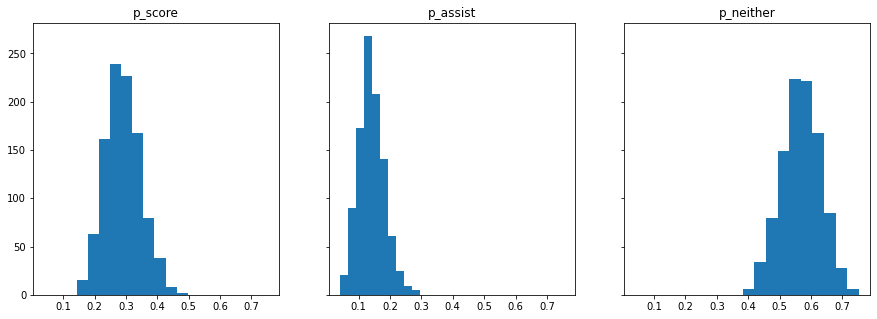

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax[0].hist(sample[:, 0])
ax[0].set_title("p_score")
ax[1].hist(sample[:, 1])
ax[1].set_title("p_assist")
ax[2].hist(sample[:, 2])
ax[2].set_title("p_neither")

In [17]:
from airsenal.framework.prediction_utils import get_player_history_df
from airsenal.framework.player_model import get_empirical_bayes_estimates

df = get_player_history_df(
    "FWD", season=CURRENT_SEASON, gameweek=NEXT_GAMEWEEK
)
df["neither"] = df["team_goals"] - df["goals"] - df["assists"]
df.loc[(df["neither"] < 0), ["neither", "team_goals", "goals", "assists"]] = [
    0.0,
    0.0,
    0.0,
    0.0,
]

emp_fwd = {}
for idx, data in df.groupby("player_id"):
    print(data["player_name"].iloc[0])
    alpha = get_empirical_bayes_estimates(data)
    emp_fwd[idx] = alpha / alpha.sum()

emp_fwd = pd.DataFrame(emp_fwd).T
emp_fwd.columns = ["emp_score", "emp_assist", "emp_neither"]
emp_fwd["name"] = [get_player(idx).name for idx in emp_fwd.index]
emp_fwd

Filling history dataframe for Harry Kane: 0/75 done
Filling history dataframe for Romelu Lukaku: 1/75 done
Filling history dataframe for Jamie Vardy: 2/75 done
Filling history dataframe for Pierre-Emerick Aubameyang: 3/75 done
Filling history dataframe for Roberto Firmino: 4/75 done
Filling history dataframe for Timo Werner: 5/75 done
Filling history dataframe for Gabriel Fernando de Jesus: 6/75 done
Filling history dataframe for Edinson Cavani: 7/75 done
Filling history dataframe for Alexandre Lacazette: 8/75 done
Filling history dataframe for Danny Ings: 9/75 done
Filling history dataframe for Dominic Calvert-Lewin: 10/75 done
Filling history dataframe for Patrick Bamford: 11/75 done
Filling history dataframe for Anthony Martial: 12/75 done
Filling history dataframe for Richarlison de Andrade: 13/75 done
Filling history dataframe for Michail Antonio: 14/75 done
Filling history dataframe for Ollie Watkins: 15/75 done
Filling history dataframe for Callum Wilson: 16/75 done
Filling hist

/Users/jroberts/GitHub/AIrsenal/airsenal/framework/player_model.py:37: RuntimeWarning: divide by zero encountered in long_scalars
  a0 = n_matches * (player_goals / team_goals) * (total_minutes / player_minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/player_model.py:37: RuntimeWarning: invalid value encountered in double_scalars
  a0 = n_matches * (player_goals / team_goals) * (total_minutes / player_minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/player_model.py:38: RuntimeWarning: divide by zero encountered in long_scalars
  a1 = n_matches * (player_assists / team_goals) * (total_minutes / player_minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/player_model.py:38: RuntimeWarning: invalid value encountered in double_scalars
  a1 = n_matches * (player_assists / team_goals) * (total_minutes / player_minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/player_model.py:45: RuntimeWarning: divide by zero encountered in long_scalars
  * (total_minut

,emp_score,emp_assist,emp_neither,name
4,0.370970,0.103047,0.525983,Pierre-Emerick Aubameyang
6,0.322452,0.197054,0.480494,Alexandre Lacazette
20,0.267096,0.053419,0.679485,Edward Nketiah
42,0.259046,0.166530,0.574424,Ollie Watkins
49,0.196756,0.039351,0.763892,Wesley Moraes
...,...,...,...,...
669,NaN,NaN,NaN,Sam Greenwood
926,0.291908,0.024326,0.683766,Romelu Lukaku
1184,NaN,NaN,NaN,Folarin Balogun
1188,1.000000,0.000000,0.000000,Adam Armstrong


In [18]:
emp_fwd

,emp_score,emp_assist,emp_neither,name
4,0.370970,0.103047,0.525983,Pierre-Emerick Aubameyang
6,0.322452,0.197054,0.480494,Alexandre Lacazette
20,0.267096,0.053419,0.679485,Edward Nketiah
42,0.259046,0.166530,0.574424,Ollie Watkins
49,0.196756,0.039351,0.763892,Wesley Moraes
...,...,...,...,...
669,NaN,NaN,NaN,Sam Greenwood
926,0.291908,0.024326,0.683766,Romelu Lukaku
1184,NaN,NaN,NaN,Folarin Balogun
1188,1.000000,0.000000,0.000000,Adam Armstrong


In [19]:
df_fit = pd.merge(df_fwd, emp_fwd, on="name", how="inner")
df_fit.set_index("name", inplace=True)

In [20]:
(df_fit["prob_score"] - df_fit["emp_score"]).dropna().sort_values()

name
Juan Camilo Hernández Suárez    -0.946813
Adam Armstrong                  -0.697765
Patrick Cutrone                 -0.185991
Emmanuel Dennis                 -0.165295
Teemu Pukki                     -0.159101
                                   ...   
Dane Scarlett                    0.290898
Nathan Broadhead                 0.290947
Marcus Forss                     0.291484
João Pedro Junqueira de Jesus    0.291824
Daniel N'Lundulu                 0.292240
Length: 64, dtype: float64

Text(0.5, 1.0, 'Player Posterior p_neither')

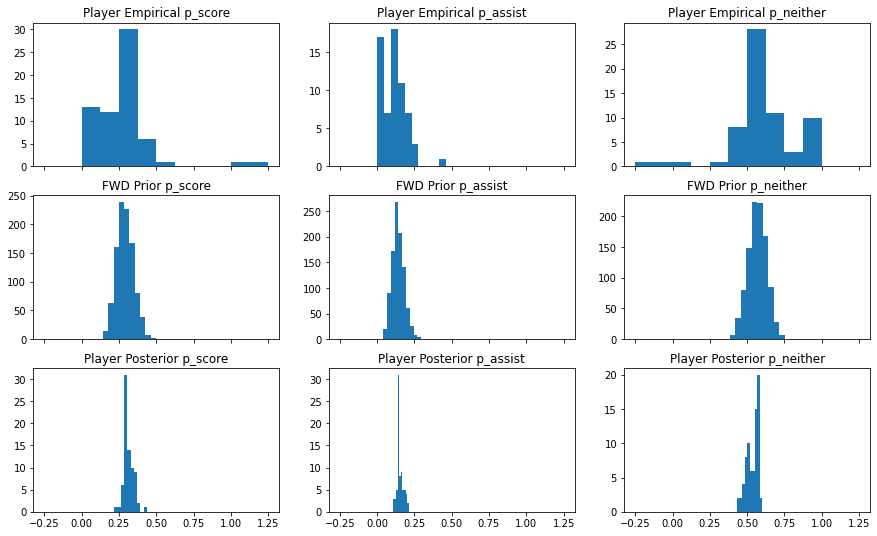

In [21]:
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=False)
ax[0, 0].hist(emp_fwd["emp_score"])
ax[0, 0].set_title("Player Empirical p_score")
ax[0, 1].hist(emp_fwd["emp_assist"])
ax[0, 1].set_title("Player Empirical p_assist")
ax[0, 2].hist(emp_fwd["emp_neither"])
ax[0, 2].set_title("Player Empirical p_neither")

ax[1, 0].hist(sample[:, 0])
ax[1, 0].set_title("FWD Prior p_score")
ax[1, 1].hist(sample[:, 1])
ax[1, 1].set_title("FWD Prior p_assist")
ax[1, 2].hist(sample[:, 2])
ax[1, 2].set_title("FWD Prior p_neither")

ax[2, 0].hist(df_fwd["prob_score"])
ax[2, 0].set_title("Player Posterior p_score")
ax[2, 1].hist(df_fwd["prob_assist"])
ax[2, 1].set_title("Player Posterior p_assist")
ax[2, 2].hist(df_fwd["prob_neither"])
ax[2, 2].set_title("Player Posterior p_neither")

In [22]:
# empirical
emp_fwd["emp_score"].describe()

count    64.000000
mean      0.266503
std       0.207105
min       0.000000
25%       0.151740
50%       0.278787
75%       0.333905
max       1.250000
Name: emp_score, dtype: float64

In [23]:
# prior
print(sample[:, 0].mean(), sample[:, 0].std())

0.29079466599812415 0.056853509320681506


In [24]:
# posterior
df_fwd["prob_score"].describe()

count    75.000000
mean      0.312273
std       0.033281
min       0.219143
25%       0.291099
50%       0.303187
75%       0.330879
max       0.436873
Name: prob_score, dtype: float64

In [25]:
df_fit.loc["Roberto Firmino"]

prob_score      0.249198
prob_assist     0.170517
prob_neither    0.580285
emp_score       0.154853
emp_assist      0.124881
emp_neither     0.720266
Name: Roberto Firmino, dtype: float64

In [26]:
emp_fwd

,emp_score,emp_assist,emp_neither,name
4,0.370970,0.103047,0.525983,Pierre-Emerick Aubameyang
6,0.322452,0.197054,0.480494,Alexandre Lacazette
20,0.267096,0.053419,0.679485,Edward Nketiah
42,0.259046,0.166530,0.574424,Ollie Watkins
49,0.196756,0.039351,0.763892,Wesley Moraes
...,...,...,...,...
669,NaN,NaN,NaN,Sam Greenwood
926,0.291908,0.024326,0.683766,Romelu Lukaku
1184,NaN,NaN,NaN,Folarin Balogun
1188,1.000000,0.000000,0.000000,Adam Armstrong


In [27]:
# exact posterior
import numpy as np
prior = np.array([24.55477665, 12.03720926, 47.90801409])
prior = 13 * prior / prior.sum()
data = np.array([17.20, 14.34, 82.46])
posterior = prior + data
posterior / posterior.sum()

array([0.16517841, 0.12749511, 0.70732649])

In [28]:
df = get_player_history_df("FWD")
df["neither"] = df["team_goals"] - df["goals"] - df["assists"]
df.loc[(df["neither"] < 0), ["neither", "team_goals", "goals", "assists"]] = [
    0.0,
    0.0,
    0.0,
    0.0,
]
alpha = get_empirical_bayes_estimates(df)
y = df.sort_values("player_id")[["goals", "assists", "neither"]].values.reshape(
    (
        df["player_id"].nunique(),
        df.groupby("player_id").count().iloc[0]["player_name"],
        3,
    )
)

minutes = df.sort_values("player_id")["minutes"].values.reshape(
    (
        df["player_id"].nunique(),
        df.groupby("player_id").count().iloc[0]["player_name"],
    )
)

nplayer = df["player_id"].nunique()
nmatch = df.groupby("player_id").count().iloc[0]["player_name"]
player_ids = np.sort(df["player_id"].unique())
alpha

Filling history dataframe for Harry Kane: 0/75 done
Filling history dataframe for Romelu Lukaku: 1/75 done
Filling history dataframe for Jamie Vardy: 2/75 done
Filling history dataframe for Pierre-Emerick Aubameyang: 3/75 done
Filling history dataframe for Roberto Firmino: 4/75 done
Filling history dataframe for Timo Werner: 5/75 done
Filling history dataframe for Gabriel Fernando de Jesus: 6/75 done
Filling history dataframe for Edinson Cavani: 7/75 done
Filling history dataframe for Alexandre Lacazette: 8/75 done
Filling history dataframe for Danny Ings: 9/75 done
Filling history dataframe for Dominic Calvert-Lewin: 10/75 done
Filling history dataframe for Patrick Bamford: 11/75 done
Filling history dataframe for Anthony Martial: 12/75 done
Filling history dataframe for Richarlison de Andrade: 13/75 done
Filling history dataframe for Michail Antonio: 14/75 done
Filling history dataframe for Ollie Watkins: 15/75 done
Filling history dataframe for Callum Wilson: 16/75 done
Filling hist

array([19.30121916,  9.36931379, 37.59613372])

In [29]:

# for compatibility with models we zero pad data so all players have
# the same number of rows (matches). Remove the dummy matches:
df = df_emp.copy()
df = df[df["match_id"] != 0]

player_goals = df["goals"].sum()
player_assists = df["assists"].sum()
player_neither = df["neither"].sum()
player_minutes = df["minutes"].sum()
team_goals = df["team_goals"].sum()
total_minutes = 90 * len(df)  # ???
n_matches = df.groupby("player_name").count()["goals"].mean()

# Total no. of player goals, assists, neither:
# no. matches played * fraction goals scored * (1 / fraction mins played)
a0 = n_matches * (player_goals / team_goals) * (total_minutes / player_minutes)
a1 = n_matches * (player_assists / team_goals) * (total_minutes / player_minutes)
a2 = (
    n_matches
    * (
        (player_neither / team_goals)
        - (total_minutes - player_minutes) / total_minutes
    )
    * (total_minutes / player_minutes)
)
alpha = np.array([a0, a1, a2])
if prior_goals is not None:
    alpha = prior_goals * (alpha / alpha.sum())
print("Alpha is {}".format(alpha))


NameError: name 'df_emp' is not defined

In [ ]:
# y
# minutes
match_id = df["match_id"].values.reshape(75, 115)

team_goals = y.sum(axis=(1, 2))
select_match = match_id != 0

n_matches = select_match.sum(axis=1)
total_minutes = 90 * n_matches
player_involvements = y.sum(axis=1)
player_minutes = minutes.sum(axis=1)

a0 = (
    n_matches
    * (player_involvements[:, 0] / team_goals)
    * (total_minutes / player_minutes)
)
a1 = (
    n_matches
    * (player_involvements[:, 1] / team_goals)
    * (total_minutes / player_minutes)
)
a2 = (
    n_matches
    * (
        (player_involvements[:, 2] / team_goals)
        - (total_minutes - player_minutes) / total_minutes
    )
    * (total_minutes / player_minutes)
)
alpha = np.stack([a0, a1, a2], axis=1)

In [ ]:
alpha

In [ ]:
alpha[0, :]

In [ ]:
# should emp bayes actually be this? (scale by nmatches)
act_goals = y[0, :].sum(axis=0)
mins_ratio = total_minutes[0] / minutes[0, :].sum()
eff_goals = act_goals[0] * mins_ratio
eff_assists = act_goals[1] * mins_ratio
eff_neither = act_goals.sum() - eff_goals - eff_assists

print(act_goals)
print(mins_ratio)
print([eff_goals, eff_assists, eff_neither])

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# or this?  (scale by mins) - BEST IMO
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
act_goals = y[0, :].sum(axis=0)
mins_ratio = total_minutes[0] / minutes[0, :].sum()
[act_goals[0], act_goals[1], (act_goals.sum() / mins_ratio) - act_goals[0] - act_goals[1]]

In [ ]:
# y
# minutes
match_id = df["match_id"].values.reshape(75, 115)

team_goals = y.sum(axis=(1, 2))
select_match = match_id != 0

n_matches = select_match.sum(axis=1)
total_minutes = 90 * n_matches
player_involvements = y.sum(axis=1)
player_minutes = minutes.sum(axis=1)

a0 = (
    n_matches
    * (player_involvements[:, 0] / team_goals)
    * (total_minutes / player_minutes)
)
a1 = (
    n_matches
    * (player_involvements[:, 1] / team_goals)
    * (total_minutes / player_minutes)
)
a2 = (
    n_matches
    * (
        (player_involvements[:, 2] / team_goals)
        - (total_minutes - player_minutes) / total_minutes
    )
    * (total_minutes / player_minutes)
)
alpha = np.stack([a0, a1, a2], axis=1)



In [ ]:
neithers = (team_goals * (player_minutes / total_minutes)) - player_involvements[:, 0] - player_involvements[:, 1]
neithers

In [ ]:
player_ids[neithers < 0]


In [ ]:
# ollie watkins: involved 40% goals but played 32% mins??? -> Looks like n_matches calculation wrong
print(get_player(42).name)
print(y[player_ids == 42].sum(axis=1))
print(minutes[player_ids == 42].sum())
print(total_minutes[player_ids == 42])
print(23 / 57)
print(3328 / 10350)

In [ ]:
print(get_player(42).name)
print(((y.sum(axis=2) > 0) & (minutes > 0)).sum(axis=1)[player_ids == 42])

print(y[player_ids == 42].sum(axis=1))
print(minutes[player_ids == 42].sum())
print(30*90)
print(23 / 57)
print(3328 / 10350)

In [ ]:
(y.sum(axis=2) > 0).shape
minutes.shape

In [ ]:
y[player_ids == 42]
n_matches[player_ids == 42]

In [ ]:
x = np.array([54, 15, 76.56444444444443])
x / x.sum()

In [ ]:
n_matches[0]

In [ ]:
alpha[0, :] / alpha[0, :].sum()

In [ ]:

n_matches[0] * (player_involvements[0, 0] / team_goals[0]) * (total_minutes[0] / player_minutes[0])


player_involvements[0, 0] * (total_minutes[0] / player_minutes[0])

In [ ]:
team_goals[0]

In [ ]:
pd.DataFrame(alpha).dropna().sort_values(by=0)

In [ ]:
y.sum(axis=2)

In [ ]:
get_player("Edinson Cavani").player_id

In [ ]:
alpha[player_ids == 307]

In [ ]:
get_player("Aubameyang").player_id

In [ ]:
alpha[player_ids == 4]

In [34]:
y.sum(axis=2).shape

(75, 115)

In [35]:
minutes.shape

(75, 115)

In [62]:
select = (y.sum(axis=2) > 0) & (minutes > 0)
select.shape

(75, 115)

In [66]:
minutes[0, select[0, :]].shape

(80,)